In [34]:
from systems.provided.futures_chapter15.basesystem import *
from sysdata.csv.csv_economic_data import csvEconomicTrendData
from systems.caleb.econotrend_poc import (
    calebRawData,
    #us_growth_rule, us_inflation_rule, us_inttrade_rule, us_monpolicy_rule
)
from sysdata.config.configdata import Config
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# data
data = csvFuturesSimData()
data.data.add_class_object(csvEconomicTrendData)

In [36]:
import pandas as pd
import datetime
from systems.trading_rules import TradingRule

def economic_trend(data, asset_class, instr_reg, rule_region, bullish, bearish):
    """
    Economic trend trading rule
    # Ags, Bond, Equity, FX, Metals, OilGas, STIR, Vol
    """
    region_match = instr_reg == rule_region
    if region_match and (asset_class in bullish):
        result = data
    elif region_match and (asset_class in bearish):
        result = -data
    else:
        result = pd.Series(0.0, index=data.index)

    min_date = data.index.min()
    max_date = datetime.datetime.now()
    daterange = pd.date_range(min_date, max_date)

    result = result.reindex(daterange)
    result = result.ffill()
    result = result.resample("1B").last()

    return result


# US Economic trend rule variation - Growth
us_growth_rule = TradingRule(
    dict(
        function=economic_trend,
        data=['rawdata.economic_trend', 'rawdata.asset_class', 'rawdata.region'],
        other_args=dict(
            _trend_name='US_GROWTH',
            rule_region='US',
            bullish=['Equity', 'Ags', 'FX', 'Metals', 'OilGas'],
            bearish=['Bond', 'STIR'],
        )
    )
)

In [37]:
# trading rules
rules = Rules(
    dict(
        etrend_growth=us_growth_rule,
        #etrend_inflation=us_inflation_rule,
        #etrend_inttrade=us_inttrade_rule,
        #etrend_monpolicy=us_monpolicy_rule,
    )
)

In [43]:
# config
config=Config()
# config.percentage_vol_target: 25.0
# config.notional_trading_capital: 2000000
# config.base_currency: "USD"

#config.instruments=["SP500_micro"]
config.instruments=["SP500_micro", "SP400", "NASDAQ"]
#config.instruments=["US2", "US5", "US10", "US30"]
#config.instruments=["DX", "SP400", "NASDAQ"]
#config.instruments=["CORN", "WHEAT", "SOYBEANS", "GOLD_micro", "CRUDE_W", "COFFEE", "SUGAR11", "LIVECOW", "FEEDCOW", "LEANHOG"]

# this parameter ensures we estimate:
config.use_forecast_scale_estimates=True
config

Config with elements: instruments, use_forecast_scale_estimates

In [44]:
# system
system = System([
   Account(), Portfolios(), PositionSizing(), calebRawData(),
   ForecastCombine(), ForecastScaleCap(), rules
], data, config)


2023-07-30 19:10:14 DEBUG base_system {'stage': 'config'} Adding config defaults


Text(0.5, 0, 'Time')

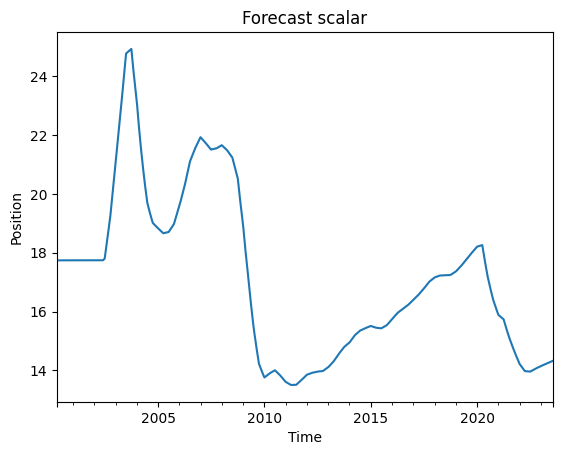

In [51]:
#instr = "SP500_micro"
#instr = "SP400"
instr = "NASDAQ"
rule = "etrend_growth"

system.forecastScaleCap.get_forecast_scalar(instr, rule).tail(5)
fc = system.forecastScaleCap.get_forecast_scalar(instr, rule)
#print(fc)
fc.plot()
plt.title('Forecast scalar')
plt.ylabel('Position')
plt.xlabel('Time')

Text(0.5, 1.0, 'Capped forecast')

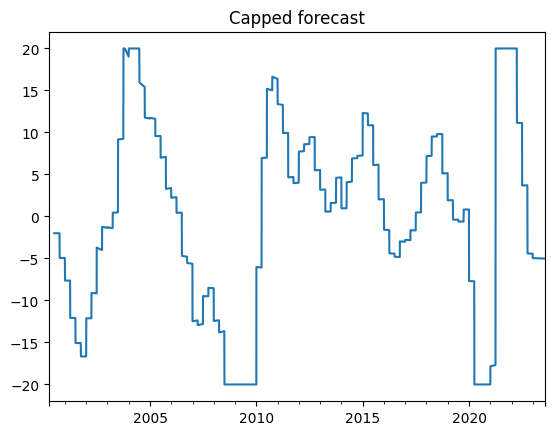

In [52]:
scf = system.forecastScaleCap.get_capped_forecast(instr, rule)
scf.plot()
plt.title('Capped forecast')


2023-07-30 19:11:24 DEBUG base_system {'stage': 'accounts', 'instrument_code': 'NASDAQ'} Calculating pandl for instrument forecast for NASDAQ etrend_growth


<AxesSubplot:>

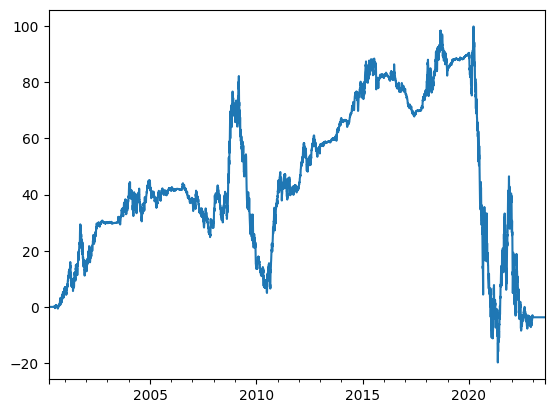

In [53]:
acc_curve_group = system.accounts.pandl_for_instrument_rules(instr)
acc_curve_group[rule].percent.curve().plot()
